# Data Hub Shapes

The shapes in the Data Hub can be organized hirarchical, so you need to prepare your input shapes accordingly. The format is as follows:

In [57]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

In [58]:
# Example of required structure for import of Shapes into Data Hub
pd.DataFrame([{
    'id': 1,
    'name': 'Germany',
    'type': 'country',
    'parent_id': None,
    'geometry': '...'
},
{
    'id': 2,
    'name': 'Baden-Würtemberg',
    'type': 'state',
    'parent_id': 1,
    'geometry': '...',
},
{
    'id': 3,
    'name': 'Hamburg',
    'type': 'state',
    'parent_id': 1,
    'geometry': '...',
},
{
    'id': 4,
    'name': 'Tübingen',
    'type': 'district',
    'parent_id': 2,
    'geometry': '...'
},
{
    'id': 5,
    'name': 'Reutlingen',
    'type': 'district',
    'parent_id': 2,
    'geometry': '...'
}])

,id,name,type,parent_id,geometry
0,1,Germany,country,NaN,...
1,2,Baden-Würtemberg,state,1.0,...
2,3,Hamburg,state,1.0,...
3,4,Tübingen,district,2.0,...
4,5,Reutlingen,district,2.0,...


# Example preparation of Admin level 0, 1 and 2

See Shape-File download: https://gadm.org/download_country.html

In [59]:
gdf0 = geopandas.read_file('../input/shapes/Districts_Shapefiles_2019/Tanzania based on Districts and TC.gpkg')
gdf1 = geopandas.read_file('../input/shapes/Districts_Shapefiles_2019/Regions Based on Districts.shp')
gdf2 = geopandas.read_file('..//input/shapes/Districts_Shapefiles_2019/Districts and TC as 2020 FIXED.shp')

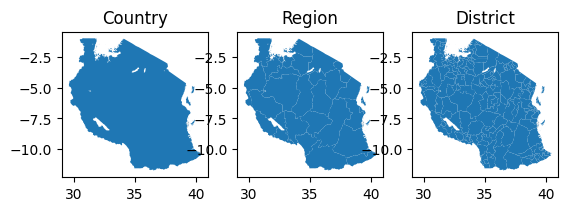

In [60]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
gdf0.plot(ax=ax0)
gdf1.plot(ax=ax1)
gdf2.plot(ax=ax2)

ax0.set_title('Country')
ax1.set_title('Region')
ax2.set_title('District')

plt.show()

# Prepare level0

In [61]:
gdf0

,Region_Nam,Region_Cod,District_C,NewDist20,geometry
0,Arusha,2,6,Arusha DC,"MULTIPOLYGON (((39.65274 -9.45981, 39.65274 -9..."


In [62]:
gdf0_new = geopandas.GeoDataFrame([{
    'name': 'Tanzania',
    'geometry': gdf0.at[0, 'geometry']
}])

In [63]:
# Rename
gdf0_new = geopandas.GeoDataFrame([{
    'name': 'Tanzania',
    'type': 'country',
    'parent_name': pd.NA,
    'properties': pd.NA,
    'geometry': gdf0.at[0, 'geometry']
}]).set_crs(gdf0.crs)

In [64]:
gdf0_new

,name,type,parent_name,properties,geometry
0,Tanzania,country,<NA>,<NA>,"MULTIPOLYGON (((39.65274 -9.45981, 39.65274 -9..."


# Prepare level1

In [65]:
gdf1.head(3)

,Region_Nam,Region_Cod,geometry
0,Dodoma,1,"MULTIPOLYGON (((36.31609 -5.52782, 36.31818 -5..."
1,Simiyu,24,"POLYGON ((34.88258 -2.99594, 34.88270 -3.00102..."
2,Singida,13,"POLYGON ((34.24180 -5.40433, 34.24180 -5.40265..."


In [66]:
# Remove uneeded columns
gdf1_new = gdf1[['Region_Nam','geometry']]

# Rename
gdf1_new = gdf1_new.rename(columns={
    'Region_Nam': 'name' 
})

gdf1_new = gdf1_new.sort_values('name', ascending=True)

# Add type columns
gdf1_new['type'] = 'region'
gdf1_new['parent_name'] = 'Tanzania'

In [67]:
gdf1_new.head(3)

,name,geometry,type,parent_name
17,Arusha,"POLYGON ((35.83179 -3.42883, 35.83153 -3.42867...",region,Tanzania
27,Dar-es-salaam,"MULTIPOLYGON (((39.31691 -6.81557, 39.31770 -6...",region,Tanzania
0,Dodoma,"MULTIPOLYGON (((36.31609 -5.52782, 36.31818 -5...",region,Tanzania


# Prepare level2

In [68]:
gdf2.head(3)

,Region_Nam,Region_Cod,District_C,NewDist20,geometry
0,Arusha,2,6,Arusha DC,"MULTIPOLYGON (((36.79314 -3.39499, 36.79285 -3..."
1,Arusha,2,3,Arusha MC,"POLYGON ((36.63328 -3.36609, 36.63297 -3.36625..."
2,Arusha,2,4,Karatu DC,"POLYGON ((35.88714 -3.26276, 35.88595 -3.26604..."


In [69]:
# Remove uneeded columns
gdf2_new = gdf2[['NewDist20', 'Region_Nam', 'geometry']]

# Rename
gdf2_new = gdf2_new.rename(columns={
    'NewDist20': 'name', 
    'Region_Nam': 'parent_name'
})

gdf2_new = gdf2_new.sort_values('name', ascending=True)

# Add type columns
gdf2_new['type'] = 'district'

In [70]:
gdf2_new.head(3)

,name,parent_name,geometry,type
0,Arusha DC,Arusha,"MULTIPOLYGON (((36.79314 -3.39499, 36.79285 -3...",district
1,Arusha MC,Arusha,"POLYGON ((36.63328 -3.36609, 36.63297 -3.36625...",district
67,Babati DC,Manyara,"POLYGON ((35.72589 -3.56723, 35.72615 -3.56744...",district


In [71]:
gdf012 = pd.concat([gdf0_new, gdf1_new, gdf2_new]).reset_index(drop=True)
gdf012.insert(0, 'id', range(1, len(gdf012)+1))

In [72]:
def get_id_for_name(name):
    dfx = gdf012[gdf012['name'] == name].reset_index(drop=True)
    
    if (len(dfx) == 0):
        return None
    return dfx.at[0, 'id']

gdf012['parent_id'] = gdf012['parent_name'].apply(get_id_for_name)

In [73]:
gdf012_final = gdf012.drop(columns=['parent_name'])

In [74]:
gdf012_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          227 non-null    int64   
 1   name        227 non-null    object  
 2   type        227 non-null    object  
 3   properties  0 non-null      object  
 4   geometry    227 non-null    geometry
 5   parent_id   226 non-null    float64 
dtypes: float64(1), geometry(1), int64(1), object(3)
memory usage: 10.8+ KB


In [75]:
gdf012_final.head(10)

,id,name,type,properties,geometry,parent_id
0,1,Tanzania,country,NaN,"MULTIPOLYGON (((39.65274 -9.45981, 39.65274 -9...",NaN
1,2,Arusha,region,NaN,"POLYGON ((35.83179 -3.42883, 35.83153 -3.42867...",1.0
2,3,Dar-es-salaam,region,NaN,"MULTIPOLYGON (((39.31691 -6.81557, 39.31770 -6...",1.0
3,4,Dodoma,region,NaN,"MULTIPOLYGON (((36.31609 -5.52782, 36.31818 -5...",1.0
4,5,Geita,region,NaN,"MULTIPOLYGON (((31.99752 -3.74578, 31.99158 -3...",1.0
5,6,Iringa,region,NaN,"POLYGON ((35.98175 -8.40394, 35.98175 -8.40396...",1.0
6,7,Kagera,region,NaN,"MULTIPOLYGON (((31.74791 -1.51667, 31.74791 -1...",1.0
7,8,Kaskazini Pemba,region,NaN,"MULTIPOLYGON (((39.64500 -5.14016, 39.64491 -5...",1.0
8,9,Kaskazini Unguja,region,NaN,"MULTIPOLYGON (((39.37027 -5.95762, 39.37123 -5...",1.0
9,10,Katavi,region,NaN,"POLYGON ((32.31989 -7.24260, 32.30045 -7.25315...",1.0


In [76]:
gdf012_final.to_file('../input/shapes/esida_tza.gpkg', index=False)